In [1]:
import fsspec
import xarray as xr
from pyproj.crs import CRS
import numpy as np

import xesmf as xe
from affine import Affine
from pathlib import Path 
import datetime


# For writing data

In [2]:
out_dir = Path('out')
out_dir.mkdir(exist_ok=True)

# Reading data

*Goal*: read grib files from this registry: https://registry.opendata.aws/noaa-hrrr-pds/. There is a really nice page that you can interactively see how the data is organized. Later in the notebook we provide some references to building urls for these grib files.

Note there are two types of files `grib2` and `zarr`. This notebook focuses on directly using `fsspec`, `cfgrib` and `xarray` to ready layers from the grib2 files.

*References for reading*:
1. https://stackoverflow.com/a/66230340
2. Error message when `filter_by_keys` keyword argument not used. See end of notebook.
3. https://github.com/ecmwf/cfgrib/issues/138#issuecomment-663549141

For atmospheric delay, we need `gh`, `q` and `t` (see their descriptions). Remove the key `cfVarName` to see all variables.

In [3]:
%%time

uri = f"simplecache::s3://noaa-hrrr-bdp-pds/hrrr_v2.20160823/conus/hrrr.t09z.wrfprsf18.grib2"

file = fsspec.open_local(uri, s3={'anon': True})

ds_q = xr.open_dataset(file, 
                       engine="cfgrib", 
                       filter_by_keys={'typeOfLevel': 'isobaricInhPa', 
                                       'cfVarName': 'q'})
ds_gh = xr.open_dataset(file, 
                        engine="cfgrib", 
                        filter_by_keys={'typeOfLevel': 'isobaricInhPa', 
                                        'cfVarName': 'gh'})
ds_t = xr.open_dataset(file, 
                       engine="cfgrib", 
                       filter_by_keys={'typeOfLevel': 'isobaricInhPa', 
                                       'cfVarName': 't'})

## Uncomment for full dataset for type of level
# ds = xr.open_dataset(file, engine="cfgrib", filter_by_keys={'typeOfLevel': 'isobaricInhPa'})

CPU times: user 9.5 s, sys: 3.09 s, total: 12.6 s
Wall time: 1min 3s


In [4]:
ds_m = xr.merge([ds_q, ds_gh, ds_t])
ds_m

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 40, y: 1059, x: 1799)
Coordinates:
    time           datetime64[ns] 2016-08-23T09:00:00
    step           timedelta64[ns] 18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1.013e+03 1e+03 975.0 ... 75.0 50.0
    latitude       (y, x) float64 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    longitude      (y, x) float64 237.3 237.3 237.3 237.4 ... 299.0 299.0 299.1
    valid_time     datetime64[ns] 2016-08-24T03:00:00
Dimensions without coordinates: y, x
Data variables:
    q              (isobaricInhPa, y, x) float32 ...
    gh             (isobaricInhPa, y, x) float32 ...
    t              (isobaricInhPa, y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-11-02T18:08 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
pressure = ds_m.isobaricInhPa
pressure

<xarray.DataArray 'isobaricInhPa' (isobaricInhPa: 40)>
array([1013., 1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,
        775.,  750.,  725.,  700.,  675.,  650.,  625.,  600.,  575.,  550.,
        525.,  500.,  475.,  450.,  425.,  400.,  375.,  350.,  325.,  300.,
        275.,  250.,  225.,  200.,  175.,  150.,  125.,  100.,   75.,   50.])
Coordinates:
    time           datetime64[ns] 2016-08-23T09:00:00
    step           timedelta64[ns] 18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1.013e+03 1e+03 975.0 ... 75.0 50.0
    valid_time     datetime64[ns] 2016-08-24T03:00:00
Attributes:
    long_name:         pressure
    units:             hPa
    positive:          down
    stored_direction:  decreasing
    standard_name:     air_pressure

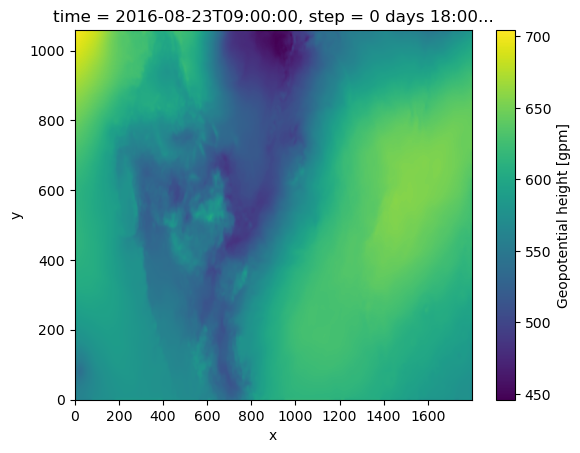

In [6]:
ds_m.sel(isobaricInhPa=pressure.data[3])['gh'].plot()

## Notes on reading

+ Pretty confident this is downloading most of the requested file *into memory* to be able to read even single variable. Currently, about 1-2 minutes for reading the requested variables.
+ Once it is cached within the compute environment, the reload is very performant. Unsure how data is effectively cached.
+ Did not test tradeoffs between reading full dataset and selecting variables vs. stacking datasets. That said, I notice that loading the entire dataset is faster after running the load of the individual layers.
+ Did not investigate difference between `hrrr_v2<date>` vs. `hrrr<date>` directories and the grib files contained within them. Herbie, which is a nice library for downloading files directly, uses the `hrrr<date>` format (see more discussion in subsequent sections below regarding building urls).
+ Here is a nice chart showing some conversions of the pressure coordinate into meters: https://www.boqueteweather.com/millibars_altitude.htm. There is a nice [formula](https://pvlib-python.readthedocs.io/en/stable/_modules/pvlib/atmosphere.html), too.

# Quick detour of Georeferencing and Reprojection/Resampling


### Using the lat/lon system (Wrong way)

As you can see above, the `grib2` file is in curvlinear coordinates meaning every `(x, y)` corresponds to a nonlinear grid of coordinates -- unlike a typical georferenced rasters where the affine transformation uniquely determines each of the arrays indices on the map. Put in another way, in this curvilinear reference system, the georeferencing is not affine. 

In the plot above, the data is in the x, y index coordinates, which appear via the indices of the matrix `0, 1, 2, ...`. The native coordinates system of the dataset is known as the "Lambert conformal conic" system, based on the `zarr` formated dataset (see [here](https://stackoverflow.com/a/69228925)). However, geotransform and coordinates are not read correctly via `xarray` and `cfgrib`. The so-called "wrong-way" is converting this array into the `(long, latitude)` system. However, the more direct, computational efficient, and elegant way is writing the  CRS, geotransform and coordinates, inferred via the zarr format.

If we have any hope of using normal GIS tools with latitude and longitude coordinate system, we are going to need to resample onto a regular grid. Not sure what the implications of this resampling is based on the native resolution.

I investigated a few different avenues for this resampling. [`xESMF`](https://xesmf.readthedocs.io/en/latest/index.html) worked great and was easiest out-of-the box. I think if a more customized CRS was required, something more along the line of [`pyresample`](https://pyresample.readthedocs.io/en/latest/) would have been more appropriate e.g. this [example](https://pyresample.readthedocs.io/en/latest/). In both cases, the libraries are easy to plug into `xarray` so you don't have to loop through variables.

In [7]:
ds_m.latitude

<xarray.DataArray 'latitude' (y: 1059, x: 1799)>
array([[21.138123  , 21.14511004, 21.1520901 , ..., 21.1545089 ,
        21.14753125, 21.14054663],
       [21.16299459, 21.1699845 , 21.17696744, ..., 21.17938723,
        21.1724067 , 21.16541921],
       [21.18786863, 21.19486142, 21.20184723, ..., 21.20426802,
        21.19728462, 21.19029425],
       ...,
       [47.78955926, 47.799849  , 47.81012868, ..., 47.81369093,
        47.80341474, 47.79312849],
       [47.81409316, 47.82438621, 47.8346692 , ..., 47.83823259,
        47.8279531 , 47.81766354],
       [47.8386235 , 47.84891986, 47.85920615, ..., 47.86277069,
        47.85248789, 47.84219502]])
Coordinates:
    time        datetime64[ns] 2016-08-23T09:00:00
    step        timedelta64[ns] 18:00:00
    latitude    (y, x) float64 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    longitude   (y, x) float64 237.3 237.3 237.3 237.4 ... 299.0 299.0 299.1
    valid_time  datetime64[ns] 2016-08-24T03:00:00
Dimensions without coordinates: y, x
Attributes:
    units:          degrees_north
    standard_name:  latitude
    long_name:      latitude

We are going to assign the standard CRS to the merged dataset (though it will not be useful currently). Mainly, this is just to copy over the dataset into a new object.

In [8]:
ds_ref = ds_m.rio.write_crs(CRS.from_epsg(4326))
# Note we are not in the normal -180, 180 range, but weirdly 270 to 540
ds_ref['longitude'] = ds_ref['longitude'] - 360
ds_ref

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 40, y: 1059, x: 1799)
Coordinates:
    time           datetime64[ns] 2016-08-23T09:00:00
    step           timedelta64[ns] 18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1.013e+03 1e+03 975.0 ... 75.0 50.0
    latitude       (y, x) float64 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    longitude      (y, x) float64 -122.7 -122.7 -122.7 ... -60.99 -60.95 -60.92
    valid_time     datetime64[ns] 2016-08-24T03:00:00
    spatial_ref    int64 0
Dimensions without coordinates: y, x
Data variables:
    q              (isobaricInhPa, y, x) float32 ...
    gh             (isobaricInhPa, y, x) float32 ...
    t              (isobaricInhPa, y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-11-02T18:08 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
xmin, xmax = ds_m.longitude.min(), ds_m.longitude.max()
ymin, ymax = ds_m.latitude.min(), ds_m.latitude.max()
xmin, ymin, xmax, ymax

(<xarray.DataArray 'longitude' ()>
 array(225.90452027)
 Coordinates:
     time        datetime64[ns] 2016-08-23T09:00:00
     step        timedelta64[ns] 18:00:00
     valid_time  datetime64[ns] 2016-08-24T03:00:00,
 <xarray.DataArray 'latitude' ()>
 array(21.138123)
 Coordinates:
     time        datetime64[ns] 2016-08-23T09:00:00
     step        timedelta64[ns] 18:00:00
     valid_time  datetime64[ns] 2016-08-24T03:00:00,
 <xarray.DataArray 'longitude' ()>
 array(299.08280723)
 Coordinates:
     time        datetime64[ns] 2016-08-23T09:00:00
     step        timedelta64[ns] 18:00:00
     valid_time  datetime64[ns] 2016-08-24T03:00:00,
 <xarray.DataArray 'latitude' ()>
 array(52.61565331)
 Coordinates:
     time        datetime64[ns] 2016-08-23T09:00:00
     step        timedelta64[ns] 18:00:00
     valid_time  datetime64[ns] 2016-08-24T03:00:00)

We are going to take $30 \times 80 = 2400$ meters or 2.4 kilometers to be our resolution, which is little bit higher than what is specified to be the approximate HRRR resolution of [3 km](https://mesowest.utah.edu/html/hrrr/). There is not a notion of an origin in the nonlinear coordinates system, so we are just going to pick the min and max of the curvilinear system and buffer it.

In [10]:
resolution = 0.0002777777777777777775 * 80
res_buffer = 3

buffer = res_buffer * resolution

longitudes = np.arange(xmin - buffer, xmax + buffer, resolution) - 360
latitudes = np.arange(ymax - buffer, ymin + buffer, -resolution)

len(longitudes), len(latitudes)

(3300, 1411)

At this point, I am going to follow the example [here](https://xesmf.readthedocs.io/en/latest/notebooks/Curvilinear_grid.html).

In [11]:
ds_out = xr.Dataset(coords={'longitude':  longitudes, 
                            'latitude':  latitudes}
                    )

And manually create an affine transform for georeferencing:

In [12]:
t = Affine(longitudes[1] - longitudes[0], 0, longitudes[0],  
           0, latitudes[1] - latitudes[0], latitudes[0])
t

Affine(0.022222222222211485, 0.0, -134.1621464009298,
       0.0, -0.022222222222225696, 52.54898664014126)

In [13]:
%%time

regridder = xe.Regridder(ds_ref, 
                         ds_out, 
                         'bilinear', 
                         unmapped_to_nan=True)

CPU times: user 3min 47s, sys: 8.04 s, total: 3min 55s
Wall time: 3min 55s


I am going to assign a new dataset to the regridded. Note how all the variables are regridded. I haven't yet looked into the nodata capabilities and how that works.

Note that `ds_out` doesn't change and is just used internally.

In [14]:
%%time

ds_ref_2 = regridder(ds_ref, 
                     keep_attrs=True)
ds_ref_2

CPU times: user 13.8 s, sys: 2.55 s, total: 16.4 s
Wall time: 16.6 s


<xarray.Dataset>
Dimensions:        (isobaricInhPa: 40, latitude: 1411, longitude: 3300)
Coordinates:
    time           datetime64[ns] 2016-08-23T09:00:00
    step           timedelta64[ns] 18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1.013e+03 1e+03 975.0 ... 75.0 50.0
    valid_time     datetime64[ns] 2016-08-24T03:00:00
    spatial_ref    int64 0
  * longitude      (longitude) float64 -134.2 -134.1 -134.1 ... -60.87 -60.85
  * latitude       (latitude) float64 52.55 52.53 52.5 ... 21.26 21.24 21.22
Data variables:
    q              (isobaricInhPa, latitude, longitude) float32 nan nan ... nan
    gh             (isobaricInhPa, latitude, longitude) float32 nan nan ... nan
    t              (isobaricInhPa, latitude, longitude) float32 nan nan ... nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-11-02T18:08 GRIB to CDM+CF via cfgrib-0.9.1...
    regrid_method:           bilinear

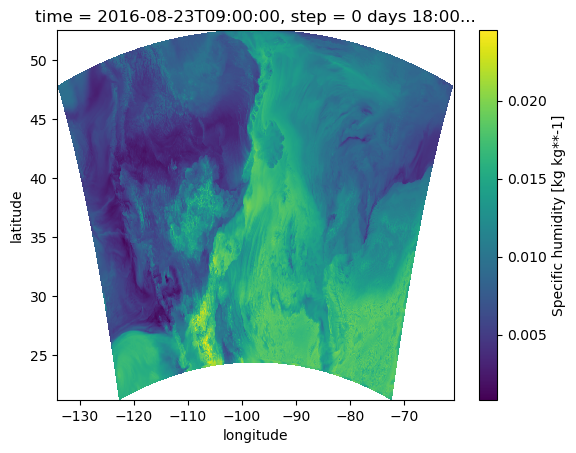

In [15]:
ds_ref_2.sel(isobaricInhPa=pressure.data[3])['q'].plot()

In [16]:
ds_ref_2.rio.write_crs(CRS.from_epsg(4326), inplace=True)

ds_ref_2.rio.write_transform(t, inplace=True)

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 40, latitude: 1411, longitude: 3300)
Coordinates:
    time           datetime64[ns] 2016-08-23T09:00:00
    step           timedelta64[ns] 18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1.013e+03 1e+03 975.0 ... 75.0 50.0
    valid_time     datetime64[ns] 2016-08-24T03:00:00
  * longitude      (longitude) float64 -134.2 -134.1 -134.1 ... -60.87 -60.85
  * latitude       (latitude) float64 52.55 52.53 52.5 ... 21.26 21.24 21.22
    spatial_ref    int64 0
Data variables:
    q              (isobaricInhPa, latitude, longitude) float32 nan nan ... nan
    gh             (isobaricInhPa, latitude, longitude) float32 nan nan ... nan
    t              (isobaricInhPa, latitude, longitude) float32 nan nan ... nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-11-02T18:08 GRIB to CDM+CF via cfgrib-0.9.1...
    regrid_method:           bilinear

We can write the data to netcdf to view it in QGIS.

In [17]:
ds_ref_2.to_netcdf(out_dir / 'sample_hrrr_4326.nc')

### Using a small box for resampling

We really don't need the whole area - only a small subset - so let's repeat the above using a small subset.

In [18]:
ds_out = xr.Dataset(coords={'longitude':  longitudes, 
                            'latitude':  latitudes}
                    )
ds_out.rio.write_crs(CRS.from_epsg(4326), inplace=True)

<xarray.Dataset>
Dimensions:      (longitude: 3300, latitude: 1411)
Coordinates:
  * longitude    (longitude) float64 -134.2 -134.1 -134.1 ... -60.87 -60.85
  * latitude     (latitude) float64 52.55 52.53 52.5 52.48 ... 21.26 21.24 21.22
    spatial_ref  int64 0
Data variables:
    *empty*

In [19]:
# xmin, ymin, xmax, ymax over CA
xmin, ymin, xmax, ymax = [-121.5, 34.95, -120.2, 36.25]
# https://gis.stackexchange.com/a/429268
ds_out_clip = ds_out.sel(longitude=slice(xmin, xmax),
                         # Note the reversal of ymin and ymax
                         latitude=slice(ymax, ymin))
ds_out_clip

<xarray.Dataset>
Dimensions:      (longitude: 59, latitude: 58)
Coordinates:
  * longitude    (longitude) float64 -121.5 -121.5 -121.5 ... -120.2 -120.2
  * latitude     (latitude) float64 36.24 36.22 36.19 ... 35.02 34.99 34.97
    spatial_ref  int64 0
Data variables:
    *empty*

In [20]:
%%time

regridder_clip = xe.Regridder(ds_ref, 
                              ds_out_clip, 
                              'bilinear', 
                              unmapped_to_nan=True)

CPU times: user 35.5 s, sys: 592 ms, total: 36.1 s
Wall time: 36.1 s


In [21]:
%%time

ds_ref_crop = regridder_clip(ds_ref, 
                             keep_attrs=True)
ds_ref_crop

CPU times: user 3.75 s, sys: 504 ms, total: 4.25 s
Wall time: 4.32 s


<xarray.Dataset>
Dimensions:        (isobaricInhPa: 40, latitude: 58, longitude: 59)
Coordinates:
    time           datetime64[ns] 2016-08-23T09:00:00
    step           timedelta64[ns] 18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1.013e+03 1e+03 975.0 ... 75.0 50.0
    valid_time     datetime64[ns] 2016-08-24T03:00:00
    spatial_ref    int64 0
  * longitude      (longitude) float64 -121.5 -121.5 -121.5 ... -120.2 -120.2
  * latitude       (latitude) float64 36.24 36.22 36.19 ... 35.02 34.99 34.97
Data variables:
    q              (isobaricInhPa, latitude, longitude) float32 0.00632 ... 8...
    gh             (isobaricInhPa, latitude, longitude) float32 14.86 ... 2.0...
    t              (isobaricInhPa, latitude, longitude) float32 303.9 ... 213.7
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-11-02T18:08 GRIB to CDM+CF via cfgrib-0.9.1...
    regrid_method:           bilinear

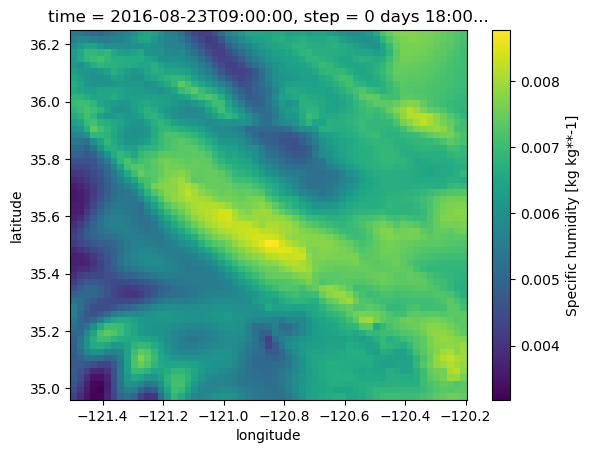

In [22]:
ds_ref_crop.sel(isobaricInhPa=pressure.data[3])['q'].plot()

So, if we pass a bounding box during resampling this can greatly increase the speed and reduce the amount of data being passed.

## Lambert Conformal Conic System (Right Way!)

When reading the zarr data (see this very excellent [intro](https://github.com/ktyle/python_pangeo_ams2021/blob/main/notebooks/03_Pangeo_HRRR.ipynb)), the Lambert CRS data was correctly read, at least in `rioxarray`. However, the current `grib2` dataset is not ingested via `xarray` in the same way though ostensibly they have the same arrays. The lack of georeferencing is highlighted below by reading the geotransform, which is centered at the origin.

In [23]:
ds_m.rio.transform()

Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)

Considering the hrrr `prs` data is consistent through time (i.e. on the same grid), I am going to just directly overwrite coordinates using the shape of the array and the geotransform obtained from the `zarr` formatted data. Interestingly, *just reassinging the coordinates* in the Lambert CRS allows rioxarray to read the geotransform. I am pretty sure it has to do with how coordinates are named in the dataset.

In [24]:
t = Affine(3000.0, 0.0, -2699020.1425219304,
           0.0, 3000.0, -1588806.1525566636)

In [25]:
xx = t.c + t.a * np.arange(ds_m.x.shape[0])
xx

array([-2699020.14252193, -2696020.14252193, -2693020.14252193, ...,
        2688979.85747807,  2691979.85747807,  2694979.85747807])

In [26]:
yy = t.f + t.e * np.arange(ds_m.y.shape[0])
yy

array([-1588806.15255666, -1585806.15255666, -1582806.15255666, ...,
        1579193.84744334,  1582193.84744334,  1585193.84744334])

In [27]:
ds_lambert = ds_m.assign_coords(x = xx, y = yy)
ds_lambert

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 40, y: 1059, x: 1799)
Coordinates:
    time           datetime64[ns] 2016-08-23T09:00:00
    step           timedelta64[ns] 18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1.013e+03 1e+03 975.0 ... 75.0 50.0
    latitude       (y, x) float64 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    longitude      (y, x) float64 237.3 237.3 237.3 237.4 ... 299.0 299.0 299.1
    valid_time     datetime64[ns] 2016-08-24T03:00:00
  * x              (x) float64 -2.699e+06 -2.696e+06 ... 2.692e+06 2.695e+06
  * y              (y) float64 -1.589e+06 -1.586e+06 ... 1.582e+06 1.585e+06
Data variables:
    q              (isobaricInhPa, y, x) float32 ...
    gh             (isobaricInhPa, y, x) float32 ...
    t              (isobaricInhPa, y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-11-02T18:08 GRIB to CDM+CF via cfgrib-0.9.1...

And as promised, the geotransform is now correctly understood:

In [28]:
ds_lambert.rio.transform()

Affine(3000.0, 0.0, -2700520.1425219304,
       0.0, 3000.0, -1590306.1525566636)

We need to also write the CRS (the `longitude_of_central_meridian` is important for referencing). We also are going to replace the nodata value in metadata and in the array if there are any.

In [29]:
# Using https://stackoverflow.com/questions/69228924/how-to-convert-zarr-data-to-geotiff/69228925#69228925
crs = CRS.from_cf({"grid_mapping_name": "lambert_conformal_conic", 
                   # This central meridian is important but not in the grib data
                   "longitude_of_central_meridian": -97.5,
                   "latitude_of_projection_origin": 38.5,
                   "standard_parallel": 38.5})
current_nodata = ds_lambert.q.attrs['GRIB_missingValue']
for var in ds_lambert.data_vars:
    ds_lambert[var] = ds_lambert[var].where(ds_lambert[var] != current_nodata)
    
[ds_lambert[var].rio.write_nodata(np.nan, inplace=True) for var in ds_lambert.data_vars]
ds_lambert.rio.write_crs(crs, inplace=True)

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 40, y: 1059, x: 1799)
Coordinates:
    time           datetime64[ns] 2016-08-23T09:00:00
    step           timedelta64[ns] 18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1.013e+03 1e+03 975.0 ... 75.0 50.0
    latitude       (y, x) float64 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    longitude      (y, x) float64 237.3 237.3 237.3 237.4 ... 299.0 299.0 299.1
    valid_time     datetime64[ns] 2016-08-24T03:00:00
  * x              (x) float64 -2.699e+06 -2.696e+06 ... 2.692e+06 2.695e+06
  * y              (y) float64 -1.589e+06 -1.586e+06 ... 1.582e+06 1.585e+06
    spatial_ref    int64 0
Data variables:
    q              (isobaricInhPa, y, x) float32 0.01668 0.01668 ... 6.831e-06
    gh             (isobaricInhPa, y, x) float32 0.8432 0.8432 ... 2.096e+04
    t              (isobaricInhPa, y, x) float32 297.4 297.4 ... 219.9 220.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-11-02T18:08 GRIB to CDM+CF via cfgrib-0.9.1...

I am guessing the CRS could be automatically generated/read from the attributes, but going to leave this alone.

In [30]:
ds_lambert.q.attrs

{'GRIB_paramId': 133,
 'GRIB_dataType': 'fc',
 'GRIB_numberOfPoints': 1905141,
 'GRIB_typeOfLevel': 'isobaricInhPa',
 'GRIB_stepUnits': 1,
 'GRIB_stepType': 'instant',
 'GRIB_gridType': 'lambert',
 'GRIB_DxInMetres': 3000.0,
 'GRIB_DyInMetres': 3000.0,
 'GRIB_LaDInDegrees': 38.5,
 'GRIB_Latin1InDegrees': 38.5,
 'GRIB_Latin2InDegrees': 38.5,
 'GRIB_LoVInDegrees': 262.5,
 'GRIB_NV': 0,
 'GRIB_Nx': 1799,
 'GRIB_Ny': 1059,
 'GRIB_cfName': 'specific_humidity',
 'GRIB_cfVarName': 'q',
 'GRIB_gridDefinitionDescription': 'Lambert Conformal can be secant or tangent, conical or bipolar',
 'GRIB_iScansNegatively': 0,
 'GRIB_jPointsAreConsecutive': 0,
 'GRIB_jScansPositively': 1,
 'GRIB_latitudeOfFirstGridPointInDegrees': 21.138123,
 'GRIB_latitudeOfSouthernPoleInDegrees': 0.0,
 'GRIB_longitudeOfFirstGridPointInDegrees': 237.280472,
 'GRIB_longitudeOfSouthernPoleInDegrees': 0.0,
 'GRIB_missingValue': 3.4028234663852886e+38,
 'GRIB_name': 'Specific humidity',
 'GRIB_shortName': 'q',
 'GRIB_units': 

`Rioxarray` doesn't like extra coords named `latitude` and `longitude`.

In [31]:
ds_m2 = ds_lambert.drop(['latitude', 'longitude'])
ds_m2

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 40, y: 1059, x: 1799)
Coordinates:
    time           datetime64[ns] 2016-08-23T09:00:00
    step           timedelta64[ns] 18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1.013e+03 1e+03 975.0 ... 75.0 50.0
    valid_time     datetime64[ns] 2016-08-24T03:00:00
  * x              (x) float64 -2.699e+06 -2.696e+06 ... 2.692e+06 2.695e+06
  * y              (y) float64 -1.589e+06 -1.586e+06 ... 1.582e+06 1.585e+06
    spatial_ref    int64 0
Data variables:
    q              (isobaricInhPa, y, x) float32 0.01668 0.01668 ... 6.831e-06
    gh             (isobaricInhPa, y, x) float32 0.8432 0.8432 ... 2.096e+04
    t              (isobaricInhPa, y, x) float32 297.4 297.4 ... 219.9 220.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-11-02T18:08 GRIB to CDM+CF via cfgrib-0.9.1...

And now, we can call the `rioxarray` reprojection to quickly reproject the variables.

In [32]:
ds_m_r = ds_m2.rio.reproject(CRS.from_epsg(4326))
ds_m_r

<xarray.Dataset>
Dimensions:        (x: 2267, y: 979, isobaricInhPa: 40)
Coordinates:
  * x              (x) float64 -134.0 -134.0 -134.0 ... -61.08 -61.05 -61.02
  * y              (y) float64 52.6 52.56 52.53 52.5 ... 21.19 21.15 21.12 21.09
    step           timedelta64[ns] 18:00:00
    time           datetime64[ns] 2016-08-23T09:00:00
    valid_time     datetime64[ns] 2016-08-24T03:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1.013e+03 1e+03 975.0 ... 75.0 50.0
    spatial_ref    int64 0
Data variables:
    q              (isobaricInhPa, y, x) float32 nan nan nan nan ... nan nan nan
    gh             (isobaricInhPa, y, x) float32 nan nan nan nan ... nan nan nan
    t              (isobaricInhPa, y, x) float32 nan nan nan nan ... nan nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-11-02T18:08 GRIB to CDM+CF via cfgrib-0.9.1...

To check the output, let's plot and write the netcdf.

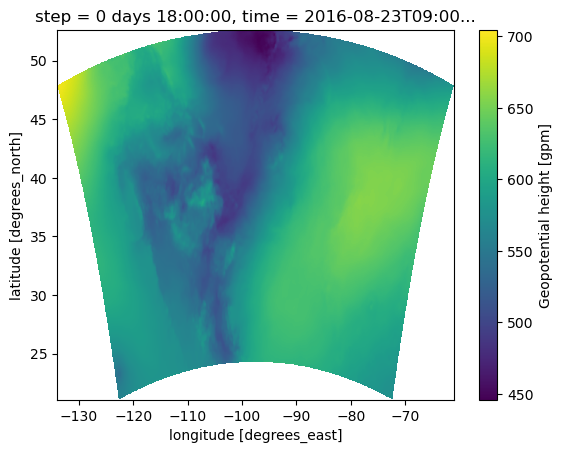

In [33]:
ds_m_r.sel(isobaricInhPa=pressure.data[3])['gh'].plot()

In [34]:
ds_m_r.to_netcdf(out_dir / '4326_from_lambert.nc')

And we can clip the data:

In [35]:
# xmin, ymin, xmax, ymax over CA
bounds = [-121.5, 34.95, -120.2, 36.25]
# https://gis.stackexchange.com/a/429268
ds_m_c = ds_m_r.rio.clip_box(*bounds)
ds_m_c

<xarray.Dataset>
Dimensions:        (x: 41, y: 42, isobaricInhPa: 40)
Coordinates:
  * x              (x) float64 -121.5 -121.5 -121.4 ... -120.3 -120.2 -120.2
  * y              (y) float64 36.26 36.23 36.2 36.17 ... 35.01 34.97 34.94
    step           timedelta64[ns] 18:00:00
    time           datetime64[ns] 2016-08-23T09:00:00
    valid_time     datetime64[ns] 2016-08-24T03:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1.013e+03 1e+03 975.0 ... 75.0 50.0
    spatial_ref    int64 0
Data variables:
    q              (isobaricInhPa, y, x) float32 0.00647 0.00576 ... 8.29e-06
    gh             (isobaricInhPa, y, x) float32 16.41 16.25 ... 2.094e+04
    t              (isobaricInhPa, y, x) float32 303.5 303.3 ... 213.7 213.7
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-11-02T18:08 GRIB to CDM+CF via cfgrib-0.9.1...

In [36]:
ds_m_c.to_netcdf(out_dir / 'clippped_4326_from_lambert_cropped.nc')

# Building urls

This python [file](https://github.com/blaylockbk/Herbie/blob/main/herbie/models/hrrr.py) from [Herbie](https://github.com/blaylockbk/Herbie) (aka `hrrrb`)is very clear on how to build urls for the above grib2 files from aws. Specifically, see this [line](https://github.com/blaylockbk/Herbie/blob/main/herbie/models/hrrr.py#L76) as to how the url is constructed. As noted in `raider` and the sample above, the product we are interested in is `prs`.

One can also use fsspec to traverse through files, which I got from [here](https://github.com/pangeo-forge/staged-recipes/issues/15#issue-771180129).

In [37]:
fs = fsspec.filesystem('s3', anon=True)

flist = fs.glob('noaa-hrrr-bdp-pds/hrrr.20190101/conus/hrrr.t*z.wrfnatf01.grib2')
flist

['noaa-hrrr-bdp-pds/hrrr.20190101/conus/hrrr.t00z.wrfnatf01.grib2',
 'noaa-hrrr-bdp-pds/hrrr.20190101/conus/hrrr.t01z.wrfnatf01.grib2',
 'noaa-hrrr-bdp-pds/hrrr.20190101/conus/hrrr.t02z.wrfnatf01.grib2',
 'noaa-hrrr-bdp-pds/hrrr.20190101/conus/hrrr.t03z.wrfnatf01.grib2',
 'noaa-hrrr-bdp-pds/hrrr.20190101/conus/hrrr.t04z.wrfnatf01.grib2',
 'noaa-hrrr-bdp-pds/hrrr.20190101/conus/hrrr.t05z.wrfnatf01.grib2',
 'noaa-hrrr-bdp-pds/hrrr.20190101/conus/hrrr.t06z.wrfnatf01.grib2',
 'noaa-hrrr-bdp-pds/hrrr.20190101/conus/hrrr.t07z.wrfnatf01.grib2',
 'noaa-hrrr-bdp-pds/hrrr.20190101/conus/hrrr.t08z.wrfnatf01.grib2',
 'noaa-hrrr-bdp-pds/hrrr.20190101/conus/hrrr.t09z.wrfnatf01.grib2',
 'noaa-hrrr-bdp-pds/hrrr.20190101/conus/hrrr.t10z.wrfnatf01.grib2',
 'noaa-hrrr-bdp-pds/hrrr.20190101/conus/hrrr.t11z.wrfnatf01.grib2',
 'noaa-hrrr-bdp-pds/hrrr.20190101/conus/hrrr.t12z.wrfnatf01.grib2',
 'noaa-hrrr-bdp-pds/hrrr.20190101/conus/hrrr.t13z.wrfnatf01.grib2',
 'noaa-hrrr-bdp-pds/hrrr.20190101/conus/hrrr.t14

For ease, let's build a sample url builder almost identical to Herbie and check it works loading data into the xarray dataset.

In [43]:
def get_hrrr_path(date: datetime.datetime,
                  product: str ='prs',
                  hrrr_region: str ='conus',
                  fxx: int = 12) -> str:
    
    assert hrrr_region in ['conus', 'alaska']
    assert (fxx <= 12) and (fxx >= 0)
    
    r_str = ''
    if hrrr_region == 'alaska':
        r_str = '.ak'
    
    path = (f"noaa-hrrr-bdp-pds/hrrr.{date:%Y%m%d}/{hrrr_region}/"
            f"hrrr.t{date:%H}z.wrf{product}f{fxx:02d}{r_str}.grib2")
    
    if not fs.exists(path):
        raise ValueError(f'The requested product path does not exist. Path: {path}')
    return path

In [39]:
path_good = get_hrrr_path(datetime.datetime(2022, 1, 1))
path_good

'noaa-hrrr-bdp-pds/hrrr.20220101/conus/hrrr.t00z.wrfprsf12.grib2'

In [40]:
path_alaska = get_hrrr_path(datetime.datetime(2022, 1, 1), hrrr_region='alaska', fxx=12)
path_alaska

'noaa-hrrr-bdp-pds/hrrr.20220101/alaska/hrrr.t00z.wrfprsf12.ak.grib2'

This path doesn't exist because it's date goes too far back

In [44]:
try:
    path_bad = get_hrrr_path(datetime.datetime(2010, 1, 1))
except ValueError as e: 
    print(e)

The requested product path does not exist. Path: noaa-hrrr-bdp-pds/hrrr.20100101/conus/hrrr.t00z.wrfprsf12.grib2


In [42]:
file_test = fsspec.open_local(f"simplecache::s3://{path_alaska}", s3={'anon': True})

xr.open_dataset(file_test, 
                engine="cfgrib", 
                filter_by_keys={'typeOfLevel': 'isobaricInhPa', 
                                'cfVarName': 'q'})

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 40, y: 919, x: 1299)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) float64 1.013e+03 1e+03 975.0 ... 75.0 50.0
    latitude       (y, x) float64 ...
    longitude      (y, x) float64 ...
    valid_time     datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    q              (isobaricInhPa, y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-11-02T18:14 GRIB to CDM+CF via cfgrib-0.9.1...

## Error message from `cfgrib` and `xarray`

```
...
File ~/opt/anaconda3/envs/xarray/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:106, in CfGribBackend.open_dataset(self, filename_or_obj, mask_and_scale, decode_times, concat_characters, decode_coords, drop_variables, use_cftime, decode_timedelta, lock, indexpath, filter_by_keys, read_keys, encode_cf, squeeze, time_dims, errors, extra_coords)
     84 def open_dataset(
     85     self,
     86     filename_or_obj: T.Union[str, abc.MappingFieldset[T.Any, abc.Field]],
   (...)
    103     extra_coords: T.Dict[str, str] = {},
    104 ) -> xr.Dataset:
--> 106     store = CfGribDataStore(
    107         filename_or_obj,
    108         indexpath=indexpath,
    109         filter_by_keys=filter_by_keys,
    110         read_keys=read_keys,
    111         encode_cf=encode_cf,
    112         squeeze=squeeze,
    113         time_dims=time_dims,
    114         lock=lock,
    115         errors=errors,
    116         extra_coords=extra_coords,
    117     )
    118     with xr.core.utils.close_on_error(store):
    119         vars, attrs = store.load()  # type: ignore

File ~/opt/anaconda3/envs/xarray/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:40, in CfGribDataStore.__init__(self, filename, lock, **backend_kwargs)
     38 else:
     39     opener = dataset.open_fieldset
---> 40 self.ds = opener(filename, **backend_kwargs)

File ~/opt/anaconda3/envs/xarray/lib/python3.10/site-packages/cfgrib/dataset.py:780, in open_file(path, grib_errors, indexpath, filter_by_keys, read_keys, time_dims, extra_coords, **kwargs)
    777 index_keys = compute_index_keys(time_dims, extra_coords)
    778 index = open_fileindex(stream, indexpath, index_keys, filter_by_keys=filter_by_keys)
--> 780 return open_from_index(index, read_keys, time_dims, extra_coords, **kwargs)

File ~/opt/anaconda3/envs/xarray/lib/python3.10/site-packages/cfgrib/dataset.py:722, in open_from_index(index, read_keys, time_dims, extra_coords, **kwargs)
    715 def open_from_index(
    716     index: abc.Index[T.Any, abc.Field],
    717     read_keys: T.Sequence[str] = (),
   (...)
    720     **kwargs: T.Any,
    721 ) -> Dataset:
--> 722     dimensions, variables, attributes, encoding = build_dataset_components(
    723         index, read_keys=read_keys, time_dims=time_dims, extra_coords=extra_coords, **kwargs
    724     )
    725     return Dataset(dimensions, variables, attributes, encoding)

File ~/opt/anaconda3/envs/xarray/lib/python3.10/site-packages/cfgrib/dataset.py:670, in build_dataset_components(index, errors, encode_cf, squeeze, log, read_keys, time_dims, extra_coords)
    668         fbks.append(fbk)
    669         error_message += "\n    filter_by_keys=%r" % fbk
--> 670     raise DatasetBuildError(error_message, key, fbks)
    671 short_name = data_var.attributes.get("GRIB_shortName", "paramId_%d" % param_id)
    672 var_name = data_var.attributes.get("GRIB_cfVarName", "unknown")

DatasetBuildError: multiple values for unique key, try re-open the file with one of:
    filter_by_keys={'typeOfLevel': 'hybrid'}
    filter_by_keys={'typeOfLevel': 'depthBelowLandLayer'}
    filter_by_keys={'typeOfLevel': 'atmosphere'}
    filter_by_keys={'typeOfLevel': 'cloudTop'}
    filter_by_keys={'typeOfLevel': 'surface'}
    filter_by_keys={'typeOfLevel': 'heightAboveGround'}
    filter_by_keys={'typeOfLevel': 'isothermal'}
    filter_by_keys={'typeOfLevel': 'pressureFromGroundLayer'}
    filter_by_keys={'typeOfLevel': 'sigmaLayer'}
    filter_by_keys={'typeOfLevel': 'meanSea'}
    filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
    filter_by_keys={'typeOfLevel': 'heightAboveGroundLayer'}
    filter_by_keys={'typeOfLevel': 'sigma'}
    filter_by_keys={'typeOfLevel': 'atmosphereSingleLayer'}
    filter_by_keys={'typeOfLevel': 'depthBelowLand'}
    filter_by_keys={'typeOfLevel': 'isobaricLayer'}
    filter_by_keys={'typeOfLevel': 'lowCloudLayer'}
    filter_by_keys={'typeOfLevel': 'middleCloudLayer'}
    filter_by_keys={'typeOfLevel': 'highCloudLayer'}
    filter_by_keys={'typeOfLevel': 'cloudBase'}
    filter_by_keys={'typeOfLevel': 'cloudCeiling'}
    filter_by_keys={'typeOfLevel': 'nominalTop'}
    filter_by_keys={'typeOfLevel': 'isothermZero'}
    filter_by_keys={'typeOfLevel': 'highestTroposphericFreezing'}
    filter_by_keys={'typeOfLevel': 'adiabaticCondensation'}
    filter_by_keys={'typeOfLevel': 'equilibrium'}
```